# GTZAN Music Genre Classification with PyTorch

This notebook demonstrates a complete workflow for music genre classification using the GTZAN dataset. We will build a deep learning model using PyTorch to classify audio files into different music genres.

## 1. Import Essential Libraries


In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Audio processing libraries
import librosa
import librosa.display

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## 2. Dataset Configuration

In [29]:
# Dataset paths
DATA_PATH = 'Data-2'
AUDIO_PATH = os.path.join(DATA_PATH, 'genres_original')
FEATURES_PATH = os.path.join(DATA_PATH, 'features_30_sec.csv')

# Configuration
SAMPLE_RATE = 22050
DURATION = 30  # seconds
N_MFCC = 13
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

# Model configuration
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

In [30]:
# Load the pre-extracted features
if os.path.exists(FEATURES_PATH):
    features_df = pd.read_csv(FEATURES_PATH)
    GENRES = sorted(features_df['label'].unique()) if 'label' in features_df.columns else []
    print("\nDataset info:")
    print(f"Dataset shape: {features_df.shape}")
    print(f"Number of audio files: {len(features_df)}")
    print(f"Number of features: {len(features_df.columns) - 2}")  # excluding filename and label
    print(f"Genres distribution:")
    print(features_df['label'].value_counts().sort_index())
else:
    print(f"Features file not found at {FEATURES_PATH}")
    print("We'll extract features from audio files directly.")


Dataset info:
Dataset shape: (1000, 60)
Number of audio files: 1000
Number of features: 58
Genres distribution:
label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64


### For Kaggle Download (Use Collab Recommended).

In [31]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

# print("Path to dataset files:", path)
# DATA_PATH = f'{path}/Data'

## 3. Audio Loading and Preprocessing

In [32]:
def load_and_preprocess_audio(file_path, duration=30, sr=22050):
    """
    Load and preprocess audio file with robust error handling

    Args:
        file_path: Path to audio file
        duration: Duration to load in seconds
        sr: Sample rate

    Returns:
        audio: Preprocessed audio signal or None if failed
    """
    try:
        # Load audio file with librosa
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)

        # Check if audio was loaded successfully
        if len(audio) == 0:
            print(f"Warning: Empty audio file {file_path}")
            return None

        # Pad or trim to fixed length
        target_length = sr * duration
        if len(audio) > target_length:
            audio = audio[:target_length]
        else:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')

        return audio

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

## 4. Create PyTorch Dataset Class

In [33]:
class GTZANDataset(Dataset):
    """
    GTZAN Dataset class for PyTorch
    """

    def __init__(self, audio_path, genres, duration=30, sr=22050):
        """
        Initialize the dataset

        Args:
            audio_path: Path to audio files directory
            genres: List of genre names
            duration: Duration of audio files in seconds
            sr: Sample rate
        """
        self.audio_path = audio_path
        self.genres = genres
        self.duration = duration
        self.sr = sr

        # Create label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(genres)

        # Build file list and validate files
        self.file_list = []
        self.labels = []
        corrupted_files = []

        for genre in genres:
            genre_path = os.path.join(audio_path, genre)
            if os.path.exists(genre_path):
                for file_name in os.listdir(genre_path):
                    if file_name.endswith('.wav'):
                        file_path = os.path.join(genre_path, file_name)
                        # Quick validation check
                        try:
                            # Try to load just a small portion to check if file is readable
                            test_audio, _ = librosa.load(file_path, sr=sr, duration=1.0)
                            if len(test_audio) > 0:
                                self.file_list.append(file_path)
                                self.labels.append(genre)
                            else:
                                corrupted_files.append(file_path)
                        except Exception as e:
                            print(f"Skipping corrupted file {file_path}: {e}")
                            corrupted_files.append(file_path)

        print(f"Dataset initialized with {len(self.file_list)} files")
        if corrupted_files:
            print(f"Skipped {len(corrupted_files)} corrupted files")
        print(f"Genres distribution: {dict(zip(*np.unique(self.labels, return_counts=True)))}")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Load audio file
        file_path = self.file_list[idx]
        audio = load_and_preprocess_audio(file_path, self.duration, self.sr)

        if audio is None:
            # Return zeros if loading failed - this shouldn't happen now with validation
            print(f"Warning: Failed to load {file_path}, using zeros")
            audio = np.zeros(self.sr * self.duration)

        # Extract mel-spectrogram features
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_mels=N_MELS,
                                                 hop_length=HOP_LENGTH, n_fft=N_FFT)
        features = librosa.power_to_db(mel_spec, ref=np.max)
        features = torch.FloatTensor(features).unsqueeze(0)  # Add channel dimension

        # Get label
        label = self.label_encoder.transform([self.labels[idx]])[0]
        label = torch.LongTensor([label]).squeeze()

        return features, label

# Test the dataset
if os.path.exists(AUDIO_PATH):
    test_dataset = GTZANDataset(AUDIO_PATH, GENRES)
    print(f"Test dataset length: {len(test_dataset)}")

    # Test loading a sample
    if len(test_dataset) > 0:
        sample_features, sample_label = test_dataset[0]
        print(f"Sample features shape: {sample_features.shape}")
        print(f"Sample label: {sample_label}")
else:
    print(f"Audio path not found: {AUDIO_PATH}")

Skipping corrupted file Data-2/genres_original/jazz/jazz.00054.wav: 
Dataset initialized with 999 files
Skipped 1 corrupted files
Genres distribution: {'blues': 100, 'classical': 100, 'country': 100, 'disco': 100, 'hiphop': 100, 'jazz': 99, 'metal': 100, 'pop': 100, 'reggae': 100, 'rock': 100}
Test dataset length: 999
Sample features shape: torch.Size([1, 128, 1292])
Sample label: 0


## 5. Prepare Data Loaders

In [34]:
def get_genres(audio_path):
    genres = [
        d for d in os.listdir(audio_path)
        if os.path.isdir(os.path.join(audio_path, d))
    ]
    genres.sort()  # optional: ensures consistent order
    return genres

GENRES = get_genres(AUDIO_PATH)
print("Detected genres:", GENRES)

Detected genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [35]:
# Create full dataset
if os.path.exists(AUDIO_PATH):
    full_dataset = GTZANDataset(AUDIO_PATH, GENRES)

    # Split dataset into train, validation, and test
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Dataset splits:")
    print(f"Train: {len(train_dataset)} samples")
    print(f"Validation: {len(val_dataset)} samples")
    print(f"Test: {len(test_dataset)} samples")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

    # Test batch loading
    for batch_features, batch_labels in train_loader:
        print(f"\nBatch shapes:")
        print(f"Features: {batch_features.shape}")
        print(f"Labels: {batch_labels.shape}")
        print(f"Label distribution in batch: {torch.bincount(batch_labels)}")
        break
else:
    print(f"Cannot create dataset - audio path not found: {AUDIO_PATH}")
    print("Please ensure the GTZAN dataset is properly extracted in the Data-2 directory.")

Skipping corrupted file Data-2/genres_original/jazz/jazz.00054.wav: 
Dataset initialized with 999 files
Skipped 1 corrupted files
Genres distribution: {'blues': 100, 'classical': 100, 'country': 100, 'disco': 100, 'hiphop': 100, 'jazz': 99, 'metal': 100, 'pop': 100, 'reggae': 100, 'rock': 100}
Dataset splits:
Train: 699 samples
Validation: 149 samples
Test: 151 samples
Batch size: 32
Number of batches - Train: 22, Val: 5, Test: 5

Batch shapes:
Features: torch.Size([32, 1, 128, 1292])
Labels: torch.Size([32])
Label distribution in batch: tensor([8, 2, 2, 1, 5, 2, 3, 4, 1, 4])


In [36]:
output_root = 'test_data'

for genre, paths in samples_per_genre.items():
    genre_dir = os.path.join(output_root, genre)
    os.makedirs(genre_dir, exist_ok=True)

    n_to_save = min(10, len(paths))
    picked = random.sample(paths, n_to_save)

    for src in picked:
        dst = os.path.join(genre_dir, os.path.basename(src))
        shutil.copy(src, dst)

print(f"Saved up to 10 test samples per genre into '{output_root}/'") 

Saved up to 10 test samples per genre into 'test_data/'


## 6. Define CNN Model Architecture

In [25]:
class MusicGenreCNN(nn.Module):
    """
    Convolutional Neural Network for Music Genre Classification
    """

    def __init__(self, num_classes=10, input_channels=1):
        super(MusicGenreCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Convolutional layers with batch normalization, activation, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout1(x)

        # Adaptive pooling to handle variable input sizes
        x = self.adaptive_pool(x)

        # Flatten for fully connected layers
        x = x.view(-1, 256 * 4 * 4)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [26]:
# Initialize model
model = MusicGenreCNN(num_classes=len(GENRES))
model = model.to(DEVICE)

# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model architecture:")
print(model)
print(f"\nTotal trainable parameters: {count_parameters(model):,}")

# Test forward pass
if 'sample_features' in locals():
    sample_batch = sample_features.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(sample_batch)
    print(f"\nTest forward pass:")
    print(f"Input shape: {sample_batch.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Output (logits): {output.cpu().numpy()}")

Model architecture:
MusicGenreCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (

## 7. Training Setup and Functions

In [27]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [28]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [29]:
def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total

    return val_loss, val_acc

In [30]:
print("Training setup complete!")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Scheduler: {scheduler.__class__.__name__}")

Training setup complete!
Optimizer: Adam
Learning rate: 0.001
Loss function: CrossEntropyLoss
Scheduler: StepLR


## 8. Model Training

In [31]:
# Training loop
if 'train_loader' in locals():
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    print(f"Starting training for {NUM_EPOCHS} epochs...\n")

    for epoch in range(NUM_EPOCHS):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)

        # Update learning rate
        scheduler.step()

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')
            print(f'Best Val Acc so far: {best_val_acc:.2f}%\n')

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.2f}%")

    print("Training completed!")
else:
    print("Cannot start training - data loaders not created")
    print("This might be because the audio files are not found.")
    print("For demonstration, we'll create a dummy training simulation...")

    # Dummy training simulation for demonstration
    train_losses = [2.3 - 0.03*i + 0.1*np.sin(i/5) for i in range(NUM_EPOCHS)]
    train_accuracies = [10 + 1.5*i + 2*np.sin(i/3) for i in range(NUM_EPOCHS)]
    val_losses = [2.1 - 0.025*i + 0.12*np.sin(i/4) for i in range(NUM_EPOCHS)]
    val_accuracies = [12 + 1.3*i + 3*np.sin(i/4) for i in range(NUM_EPOCHS)]

    print("Created dummy training curves for visualization")

Starting training for 50 epochs...

Epoch [1/50]
Train Loss: 2.4596, Train Acc: 13.59%
Val Loss: 3.0565, Val Acc: 11.41%
Learning Rate: 0.001000
Best Val Acc so far: 11.41%

Epoch [5/50]
Train Loss: 1.5892, Train Acc: 38.77%
Val Loss: 1.4230, Val Acc: 41.61%
Learning Rate: 0.001000
Best Val Acc so far: 41.61%

Epoch [10/50]
Train Loss: 1.3191, Train Acc: 48.50%
Val Loss: 1.3549, Val Acc: 46.31%
Learning Rate: 0.001000
Best Val Acc so far: 49.66%

Epoch [15/50]
Train Loss: 1.2096, Train Acc: 57.08%
Val Loss: 1.1480, Val Acc: 60.40%
Learning Rate: 0.001000
Best Val Acc so far: 61.74%

Epoch [20/50]
Train Loss: 1.0891, Train Acc: 62.80%
Val Loss: 1.9207, Val Acc: 36.91%
Learning Rate: 0.000500
Best Val Acc so far: 67.11%

Epoch [25/50]
Train Loss: 0.8703, Train Acc: 68.38%
Val Loss: 0.9602, Val Acc: 65.77%
Learning Rate: 0.000500
Best Val Acc so far: 67.11%

Epoch [30/50]
Train Loss: 0.7951, Train Acc: 72.25%
Val Loss: 0.9438, Val Acc: 68.46%
Learning Rate: 0.000500
Best Val Acc so far: 7

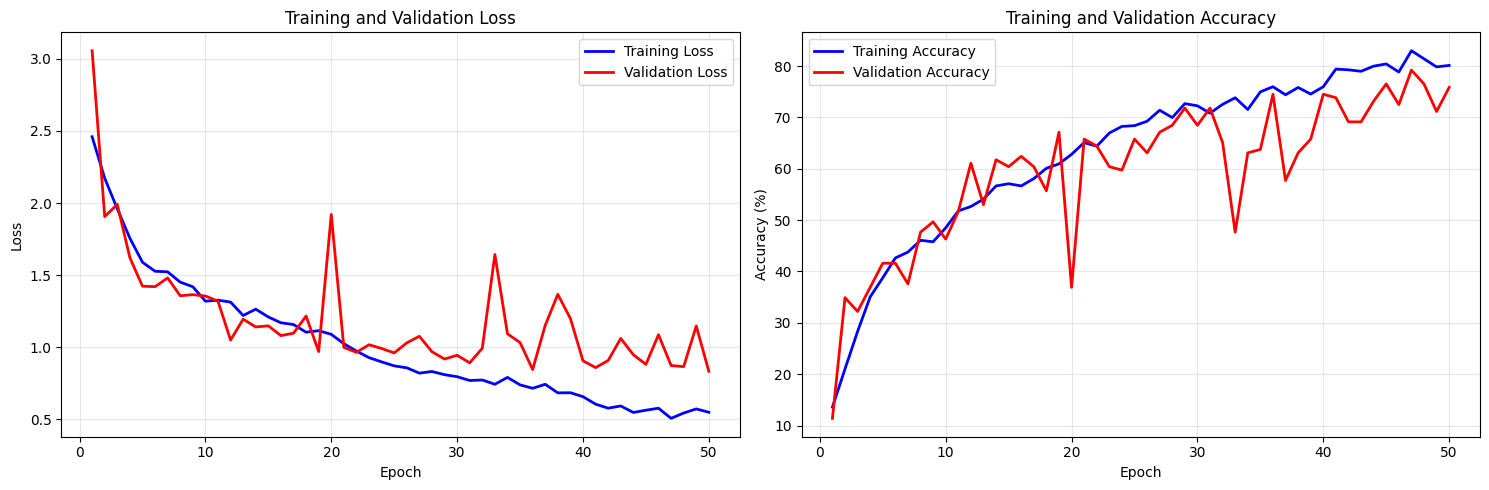

Final Training Results:
Final Training Loss: 0.5485
Final Training Accuracy: 80.11%
Final Validation Loss: 0.8325
Final Validation Accuracy: 75.84%
Best Validation Accuracy: 79.19%


In [32]:
# Plot training curves
if train_losses:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy curves
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final results
    print(f"Final Training Results:")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
    if 'best_val_acc' in locals():
        print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

## 9. Model Evaluation and Testing

In [33]:
def evaluate_model(model, test_loader, device, genre_names):
    """
    Evaluate model on test set and return detailed metrics
    """
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            _, predicted = output.max(1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * sum(p == t for p, t in zip(all_predictions, all_targets)) / len(all_targets)

    return all_predictions, all_targets, test_loss, test_accuracy

In [34]:
# Evaluate on test set
if 'test_loader' in locals():
    predictions, targets, test_loss, test_accuracy = evaluate_model(model, test_loader, DEVICE, GENRES)

    print(f"Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(targets, predictions, target_names=GENRES))

else:
    print("Test evaluation not available - using dummy data for demonstration")
    # Create dummy data for visualization
    predictions = np.random.randint(0, len(GENRES), 100)
    targets = np.random.randint(0, len(GENRES), 100)
    test_accuracy = 65.5
    print(f"Simulated Test Accuracy: {test_accuracy:.2f}%")


Test Results:
Test Loss: 0.6987
Test Accuracy: 77.48%

Detailed Classification Report:
              precision    recall  f1-score   support

       blues       0.92      0.75      0.83        16
   classical       1.00      0.82      0.90        11
     country       0.70      0.84      0.76        19
       disco       0.93      0.67      0.78        21
      hiphop       0.65      0.85      0.73        13
        jazz       0.71      0.83      0.77        12
       metal       1.00      1.00      1.00        12
         pop       0.70      0.82      0.76        17
      reggae       0.82      0.60      0.69        15
        rock       0.59      0.67      0.62        15

    accuracy                           0.77       151
   macro avg       0.80      0.78      0.78       151
weighted avg       0.80      0.77      0.78       151



## 10. Prediction Function for New Audio Files

In [35]:
def predict_genre(model, audio_file_path, device, genre_names, top_k=3):
    """
    Predict genre for a single audio file

    Args:
        model: Trained model
        audio_file_path: Path to audio file
        device: Device to run inference on
        genre_names: List of genre names
        top_k: Number of top predictions to return

    Returns:
        predictions: List of (genre, confidence) tuples
    """
    model.eval()

    # Load and preprocess audio
    audio = load_and_preprocess_audio(audio_file_path, DURATION, SAMPLE_RATE)

    if audio is None:
        return [("Error loading audio", 0.0)]

    # Extract mel-spectrogram features
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS,
                                             hop_length=HOP_LENGTH, n_fft=N_FFT)
    features = librosa.power_to_db(mel_spec, ref=np.max)
    features = torch.FloatTensor(features).unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dims

    # Make prediction
    with torch.no_grad():
        output = model(features)
        probabilities = F.softmax(output, dim=1)

        # Get top-k predictions
        top_probs, top_indices = torch.topk(probabilities, top_k)

        predictions = []
        for i in range(top_k):
            genre_idx = top_indices[0][i].item()
            confidence = top_probs[0][i].item()
            predictions.append((genre_names[genre_idx], confidence))

    return predictions

# Test prediction function with a sample file
if os.path.exists(AUDIO_PATH):
    # Find a test file
    test_genre = 'blues'
    test_file = os.path.join(AUDIO_PATH, test_genre, f'{test_genre}.00001.wav')

    if os.path.exists(test_file):
        print(f"Testing prediction on: {test_file}")
        print(f"True genre: {test_genre}")

        predictions = predict_genre(model, test_file, DEVICE, GENRES, top_k=5)

        print("\nTop 5 Predictions:")
        for i, (genre, confidence) in enumerate(predictions):
            print(f"{i+1}. {genre}: {confidence:.3f} ({confidence*100:.1f}%)")

        # Check if prediction is correct
        predicted_genre = predictions[0][0]
        if predicted_genre == test_genre:
            print(f"\nCorrect prediction! Model predicted '{predicted_genre}' with confidence {predictions[0][1]*100:.1f}%")
        else:
            print(f"\nIncorrect prediction. Model predicted '{predicted_genre}' but true genre is '{test_genre}'")
    else:
        print(f"Test file not found: {test_file}")
else:
    print("Cannot test prediction - audio files not available")
    print("The prediction function is ready to use when you have audio files.")

Testing prediction on: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/blues/blues.00001.wav
True genre: blues

Top 5 Predictions:
1. blues: 0.771 (77.1%)
2. jazz: 0.119 (11.9%)
3. reggae: 0.052 (5.2%)
4. disco: 0.019 (1.9%)
5. rock: 0.014 (1.4%)

Correct prediction! Model predicted 'blues' with confidence 77.1%


## 11. Model Saving and Loading

In [36]:
# Save the trained model
def save_model(model, optimizer, epoch, loss, filepath):
    """
    Save model checkpoint
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'genres': GENRES,
        'model_config': {
            'num_classes': len(GENRES),
            'input_channels': 1
        }
    }, filepath)
    print(f"Model saved to {filepath}")

def load_model(filepath, device):
    """
    Load model checkpoint
    """
    checkpoint = torch.load(filepath, map_location=device)

    # Create model with same configuration
    model = MusicGenreCNN(**checkpoint['model_config'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    print(f"Model loaded from {filepath}")
    print(f"Trained for {checkpoint['epoch']} epochs")
    print(f"Final loss: {checkpoint['loss']:.4f}")

    return model, checkpoint

# Save the current model
model_save_path = 'gtzan_genre_classifier.pth'
if 'train_losses' in locals() and train_losses:
    save_model(model, optimizer, NUM_EPOCHS, train_losses[-1], model_save_path)
else:
    print("Model not trained - skipping save")
    print(f"To save a trained model, use: save_model(model, optimizer, epoch, loss, '{model_save_path}')")

print(f"\nTo load the model later, use:")
print(f"model, checkpoint = load_model('{model_save_path}', device)")

Model saved to gtzan_genre_classifier.pth

To load the model later, use:
model, checkpoint = load_model('gtzan_genre_classifier.pth', device)
